In [ ]:
# Instalação de pacotes necessários
try:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
    from wordcloud import WordCloud
    import kagglehub
except ImportError:
    # Instalar pacotes ausentes
    !pip install numpy pandas matplotlib seaborn scikit-learn scipy wordcloud kagglehub
    # Importações após a instalação
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
    from wordcloud import WordCloud
    import kagglehub

# Configuração de estilos e ajustes gerais
plt.style.use('dark_background')  # Define fundo escuro para os gráficos

# Dataset

In [ ]:
# Célula 1: Download do Dataset
import os
import shutil
import kagglehub

# Download do dataset e obtenção do diretório base
path = kagglehub.dataset_download("rohan0301/unsupervised-learning-on-country-data")

# Localizando dinamicamente o arquivo CSV no diretório baixado
dataset_path = os.path.join(path, "Country-data.csv")

# Definindo o caminho de destino na subpasta "datasets"
destination_folder = os.path.join(os.getcwd(), "datasets")
os.makedirs(destination_folder, exist_ok=True)  # Cria a pasta "datasets" se não existir
destination_path = os.path.join(destination_folder, "Country-data.csv")

# Movendo o arquivo para a subpasta "datasets"
shutil.copy(dataset_path, destination_path)
print("Dataset copiado para:", destination_path)

Dataset copiado para: c:\ML\Cluster\datasets\Country-data.csv


In [24]:
# Célula 2: Carregamento e Análise Inicial do Dataset

# Importação
import pandas as pd

# Carregando o dataset (caminho dinâmico definido na Célula 1)
data = pd.read_csv(dataset_path)

# Visualizando as primeiras linhas do dataset
print("Visualizando as primeiras linhas do dataset:")
print(data.head())

# Contando o número de países únicos
num_countries = data['country'].nunique()
print(f"\nNúmero de países no dataset: {num_countries}")

# Removendo a coluna de país para análise numérica
data_without_country = data.drop(columns=["country"])

# Visualizando estatísticas descritivas para a faixa dinâmica
print("\nFaixa dinâmica das variáveis:")
print(data_without_country.describe())


Visualizando as primeiras linhas do dataset:
               country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  
0       9.44        56.2       5.82    553  
1       4.49        76.3       1.65   4090  
2      16.10        76.5       2.89   4460  
3      22.40        60.1       6.16   3530  
4       1.44        76.8       2.13  12200  

Número de países no dataset: 167

Faixa dinâmica das variáveis:
       child_mort     exports      health     imports         income  \
count  167.000000  167.000000  167.000000  167.000000     167.000000   
mean    38.270060   41.108976    6.815689  

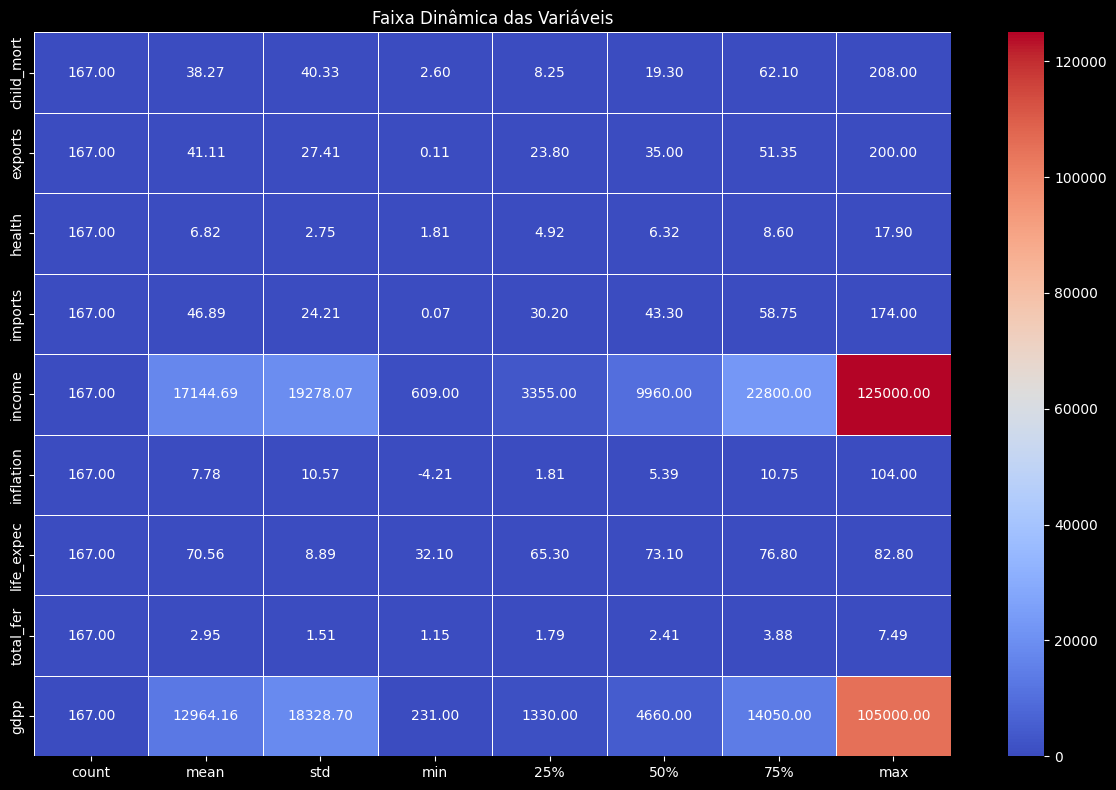

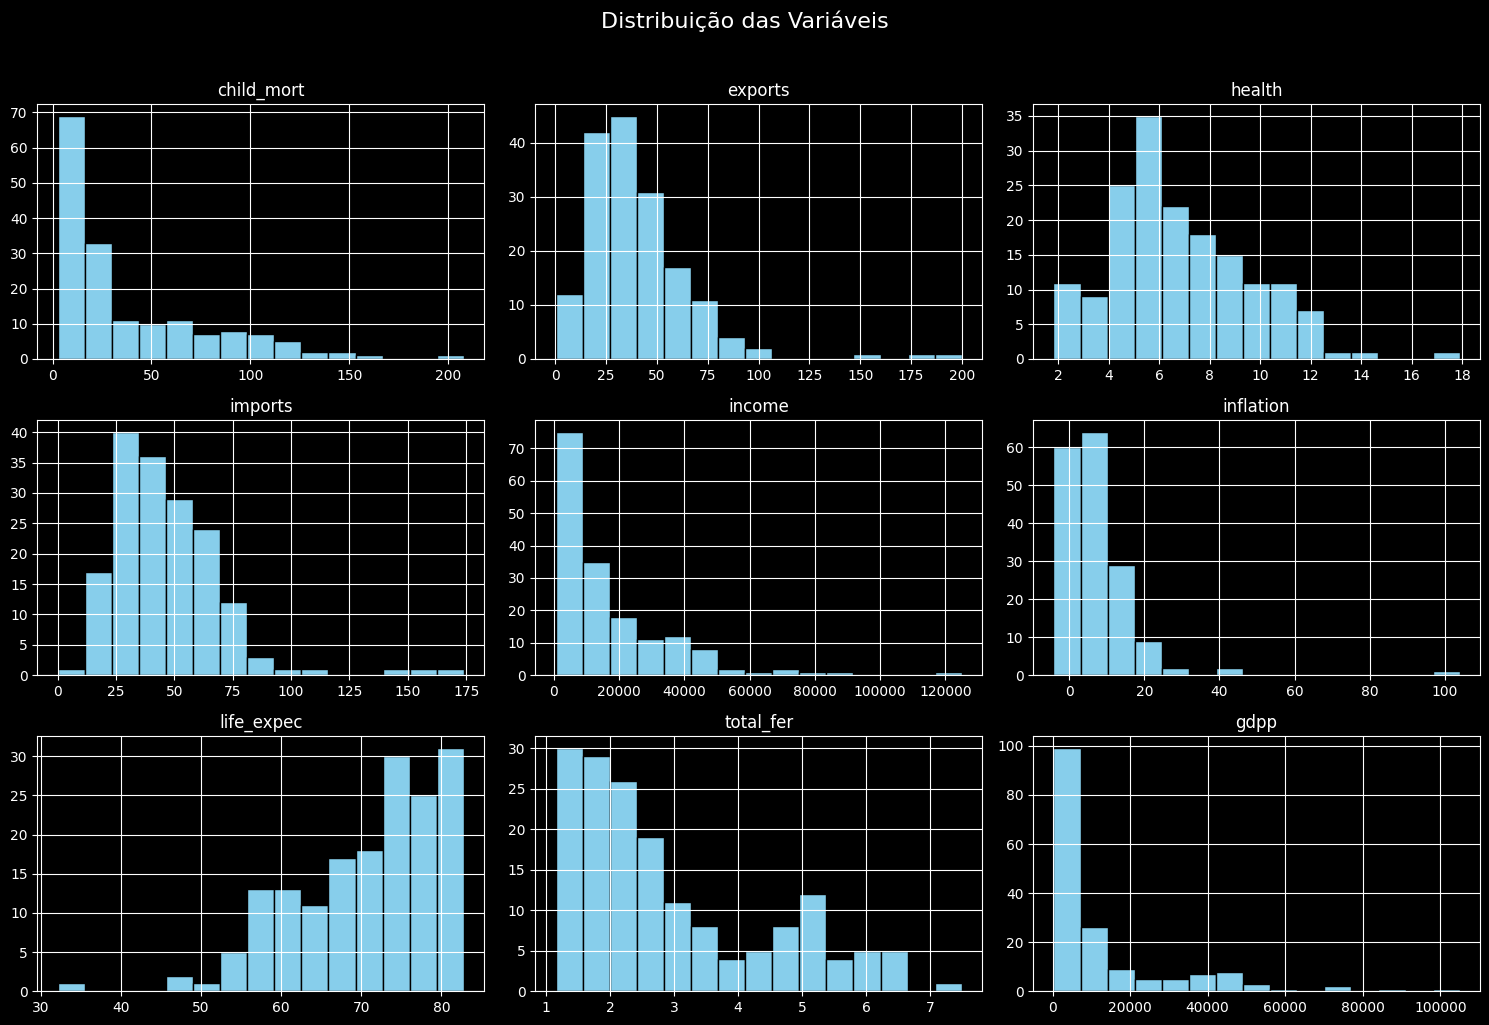

In [ ]:
# Célula 3: Visualização da Faixa Dinâmica

# Importações
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração do estilo
plt.style.use('dark_background')

# Gráfico alternativo: Heatmap para faixa dinâmica
plt.figure(figsize=(12, 8))
sns.heatmap(data_without_country.describe().T, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Faixa Dinâmica das Variáveis")
plt.tight_layout()
plt.show()

# Gráfico alternativo: Histogramas das variáveis
data_without_country.hist(bins=15, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle("Distribuição das Variáveis", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


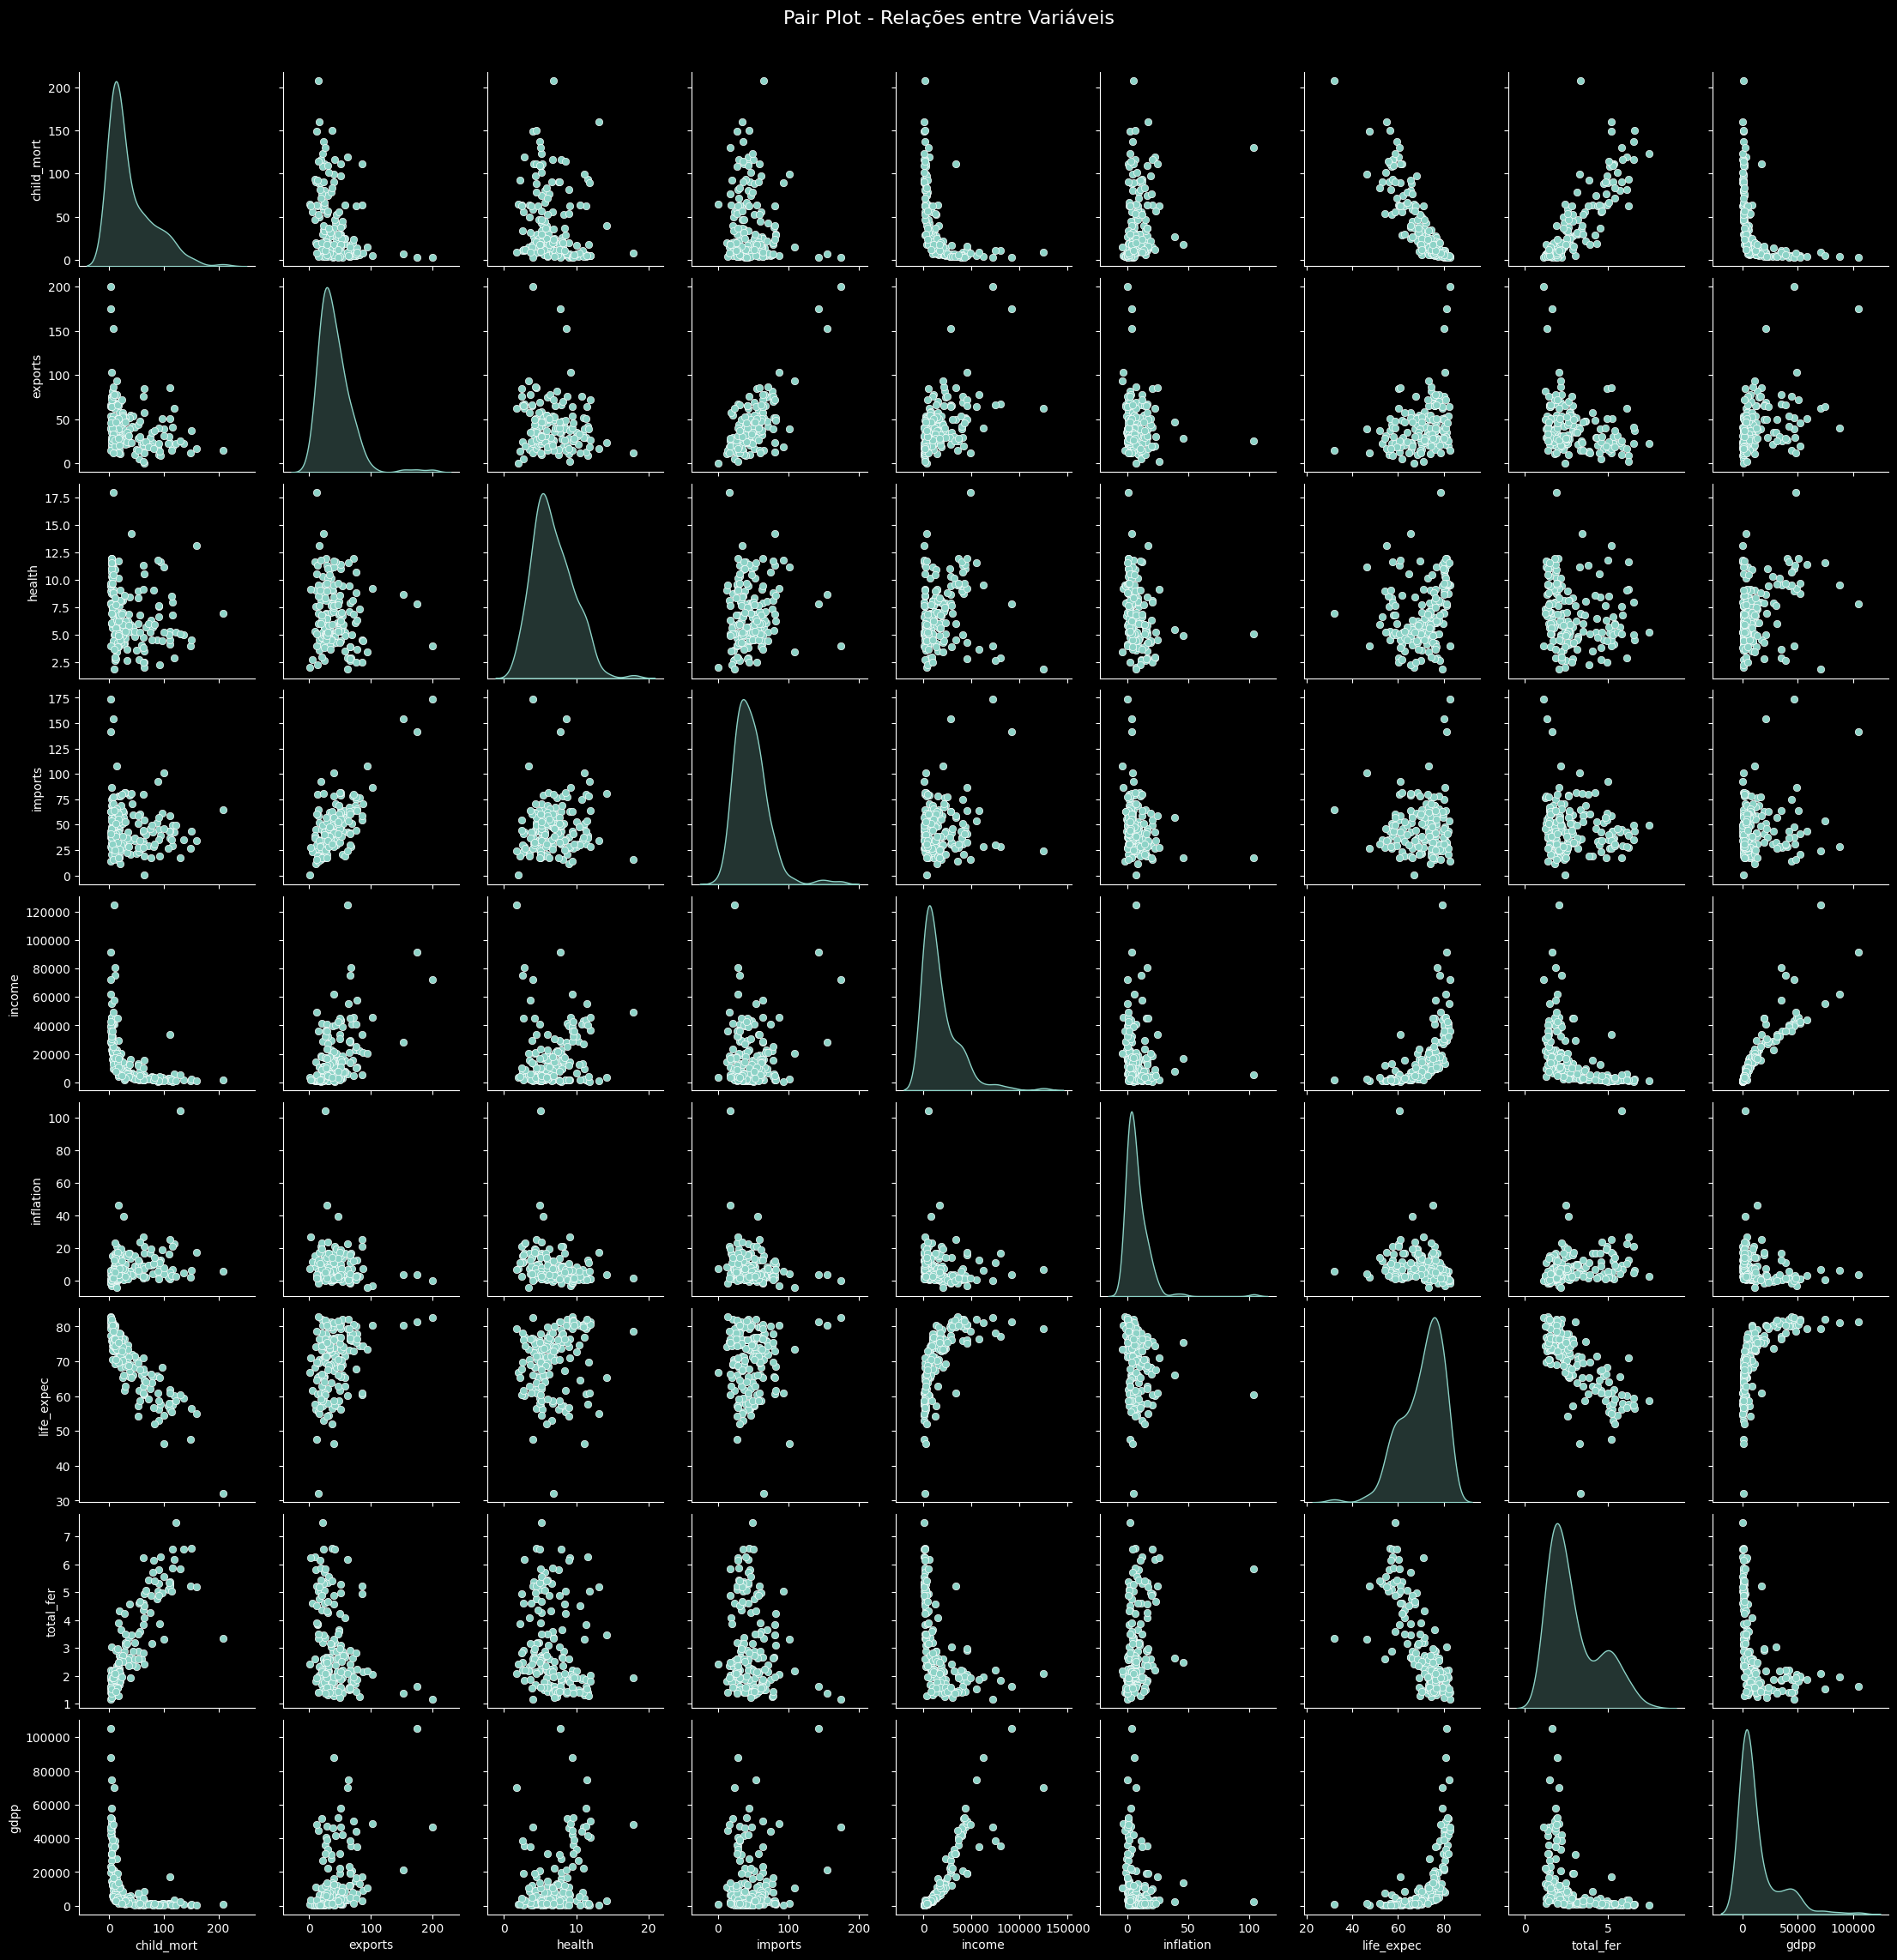

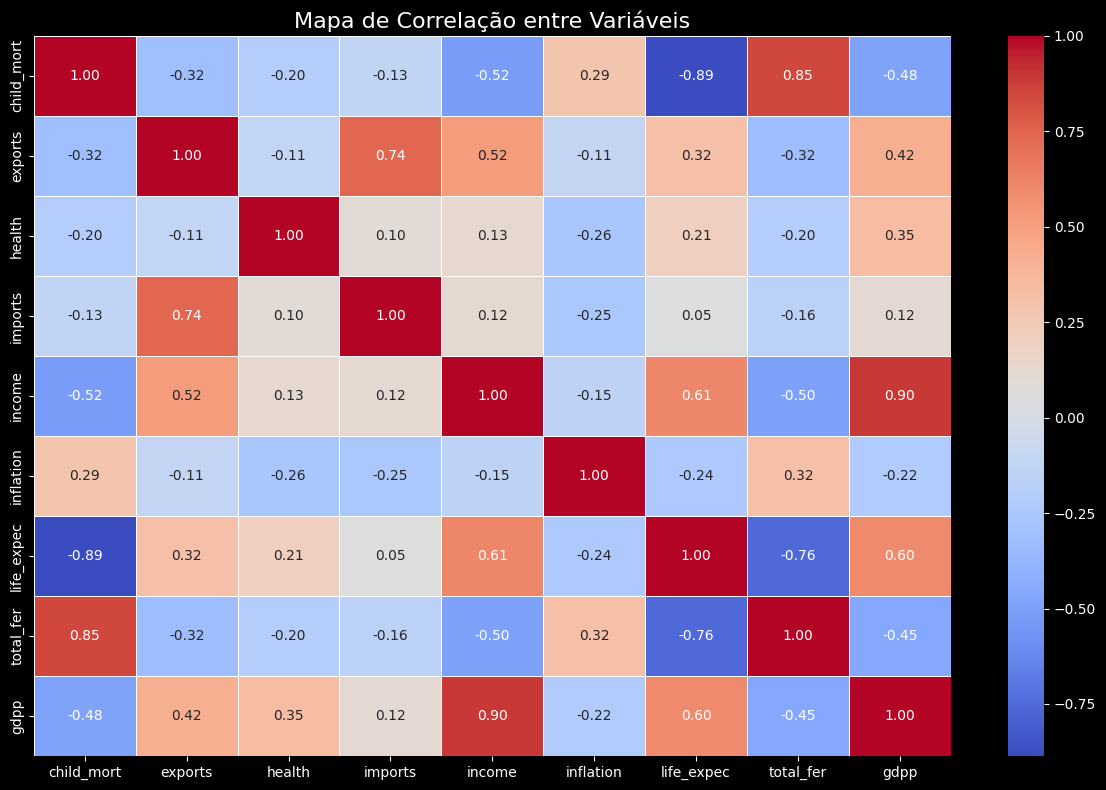

In [7]:
# Célula 3: Visualizações para Clusterização



# Importações
import seaborn as sns
import matplotlib.pyplot as plt

# Configuração do estilo para fundo escuro
plt.style.use('dark_background')

# 1. Pair Plot (Scatter Matrix)
# Este gráfico exibe pares de variáveis em gráficos de dispersão para observar agrupamentos ou tendências
sns.pairplot(data_without_country, diag_kind='kde')
plt.suptitle("Pair Plot - Relações entre Variáveis", y=1.02, fontsize=16)
plt.show()

# 2. Mapa de Correlação
# Este gráfico mostra a correlação entre variáveis em forma de matriz, destacando relações lineares fortes ou fracas
plt.figure(figsize=(12, 8))
correlation_matrix = data_without_country.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Mapa de Correlação entre Variáveis", fontsize=16)
plt.tight_layout()
plt.show()


# Pre Processing

In [8]:
# Célula 4: Pré-Processamento dos Dados

# Verificando valores ausentes
print("Valores ausentes por coluna:")
print(data_without_country.isnull().sum())

# Preenchendo valores ausentes com a média (se houver)
data_preprocessed = data_without_country.fillna(data_without_country.mean())

# Normalização (Standard Scaling)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_preprocessed)

# Convertendo de volta para DataFrame com os mesmos nomes de colunas
data_normalized = pd.DataFrame(data_normalized, columns=data_preprocessed.columns)

# Detectando outliers usando o intervalo interquartil (IQR)
Q1 = data_preprocessed.quantile(0.25)
Q3 = data_preprocessed.quantile(0.75)
IQR = Q3 - Q1
outliers = ((data_preprocessed < (Q1 - 1.5 * IQR)) | (data_preprocessed > (Q3 + 1.5 * IQR))).sum()

print("\nNúmero de outliers por variável:")
print(outliers)

# Removendo outliers (dependendo do impacto)
data_cleaned = data_preprocessed[~((data_preprocessed < (Q1 - 1.5 * IQR)) | (data_preprocessed > (Q3 + 1.5 * IQR))).any(axis=1)]

# Exibindo as estatísticas finais
print("\nEstatísticas após pré-processamento:")
print(data_cleaned.describe())


Valores ausentes por coluna:
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

Número de outliers por variável:
child_mort     4
exports        5
health         2
imports        4
income         8
inflation      5
life_expec     3
total_fer      1
gdpp          25
dtype: int64

Estatísticas após pré-processamento:
       child_mort     exports      health     imports        income  \
count  128.000000  128.000000  128.000000  128.000000    128.000000   
mean    38.799219   37.427336    6.345000   45.127077  11149.851562   
std     33.964248   18.794958    2.213079   17.771282   9774.820899   
min      3.200000    0.109000    1.970000    0.065900    609.000000   
25%     11.700000   23.550000    4.912500   31.375000   3225.000000   
50%     24.100000   34.000000    6.005000   43.500000   8510.000000   
75%     62.200000   50.275000    7.790000   57.650000  16050.000000   
max    1

In [9]:
data_cleaned.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


# Clutering 

## K-Mean

Países mais próximos dos centróides de cada cluster:
Cluster 0: Uzbekistan
Cluster 1: Spain
Cluster 2: Panama


c:\ML\Cluster\cluster_1\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


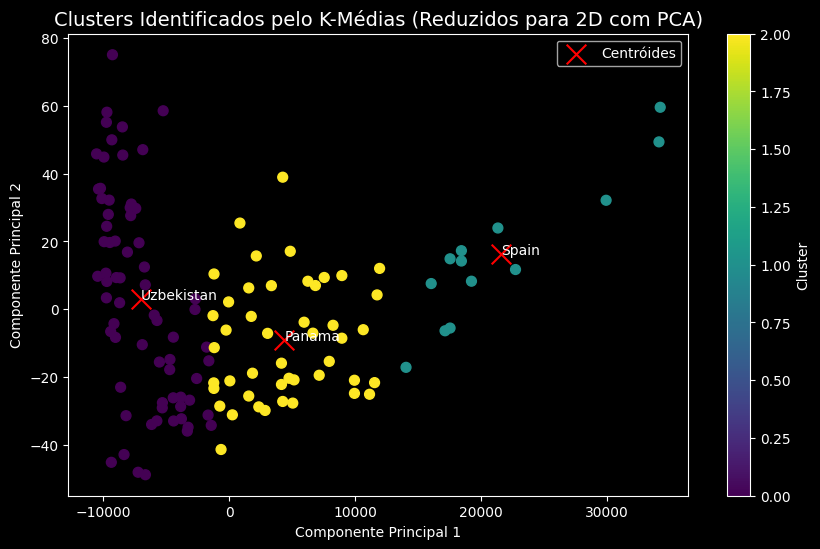

In [12]:
# Célula 5: Clusterização com K-Médias (com centróides nomeados no gráfico)

# Importações
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Aplicando o K-Médias com 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data_cleaned.iloc[:, :-2])  # Apenas colunas numéricas originais

# Adicionando os rótulos dos clusters aos dados
data_cleaned = data_cleaned.copy()  # Evita o aviso
data_cleaned['Cluster_KMeans'] = kmeans.labels_

# Calculando os centróides dos clusters
centroids = kmeans.cluster_centers_

# Encontrando o país mais próximo de cada centróide
country_names = data.loc[data_cleaned.index, 'country']  # Recuperando os nomes dos países
centroid_countries = []

for i, centroid in enumerate(centroids):
    # Usando apenas as colunas numéricas originais para calcular as distâncias
    distances = np.linalg.norm(data_cleaned.iloc[:, :-2].values - centroid, axis=1)
    closest_country_index = distances.argmin()
    closest_country = country_names.iloc[closest_country_index]
    centroid_countries.append(closest_country)

# Exibindo os nomes dos países mais próximos dos centróides
print("Países mais próximos dos centróides de cada cluster:")
for i, country in enumerate(centroid_countries):
    print(f"Cluster {i}: {country}")

# Visualizando os clusters em um gráfico 2D (usando PCA para reduzir a dimensionalidade)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_cleaned.iloc[:, :-2])  # Apenas colunas numéricas originais

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    data_pca[:, 0], data_pca[:, 1], 
    c=data_cleaned['Cluster_KMeans'], cmap='viridis', s=50
)

# Adicionando os centróides ao gráfico
centroids_pca = pca.transform(centroids)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
            c='red', marker='x', s=200, label='Centróides')

# Adicionando os nomes dos países próximos aos centróides
for i, txt in enumerate(centroid_countries):
    plt.annotate(txt, (centroids_pca[i, 0], centroids_pca[i, 1]), fontsize=10, color='white')

plt.title("Clusters Identificados pelo K-Médias (Reduzidos para 2D com PCA)", fontsize=14)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.show()


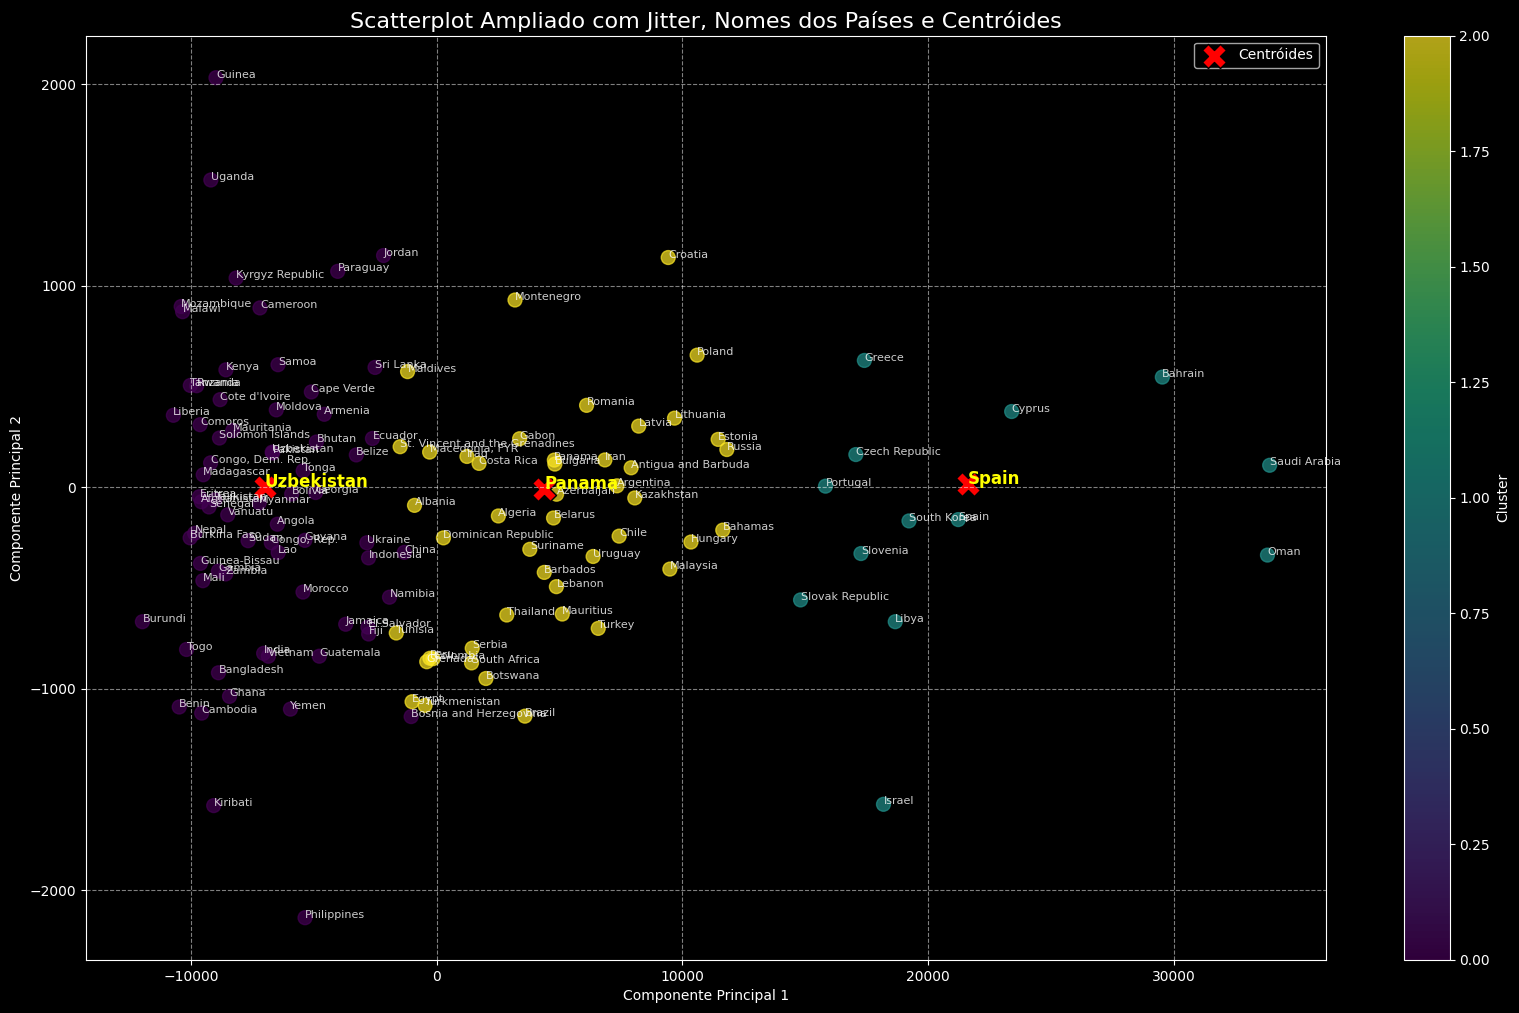

In [13]:
# Célula 5.5: Scatterplot Ampliado com Jitter, Nomes dos Países e Centróides

import matplotlib.pyplot as plt
import numpy as np

# Adicionando jitter (ruído aleatório pequeno) às coordenadas
jitter_strength = 600  # Ajuste para controlar a intensidade do espalhamento
data_pca_jittered = data_pca + np.random.normal(0, jitter_strength, data_pca.shape)


# Plotando os clusters em 2D com centróides destacados
plt.figure(figsize=(20, 12))
scatter = plt.scatter(
    data_pca_jittered[:, 0], data_pca_jittered[:, 1],
    c=data_cleaned['Cluster_KMeans'], cmap='viridis', s=100, alpha=0.7
)

# Adicionando os nomes dos países a cada ponto
for i, txt in enumerate(country_names):
    plt.annotate(txt, (data_pca_jittered[i, 0], data_pca_jittered[i, 1]), fontsize=8, alpha=0.8, color='white')

# Adicionando os centróides ao gráfico (sem jitter nos centróides)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
            c='red', marker='X', s=300, label='Centróides', edgecolors='black')

# Adicionando os nomes dos países próximos aos centróides
for i, txt in enumerate(centroid_countries):
    plt.annotate(txt, (centroids_pca[i, 0], centroids_pca[i, 1]), fontsize=12, color='yellow', weight='bold')

plt.title("Scatterplot Ampliado com Jitter, Nomes dos Países e Centróides", fontsize=16)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()



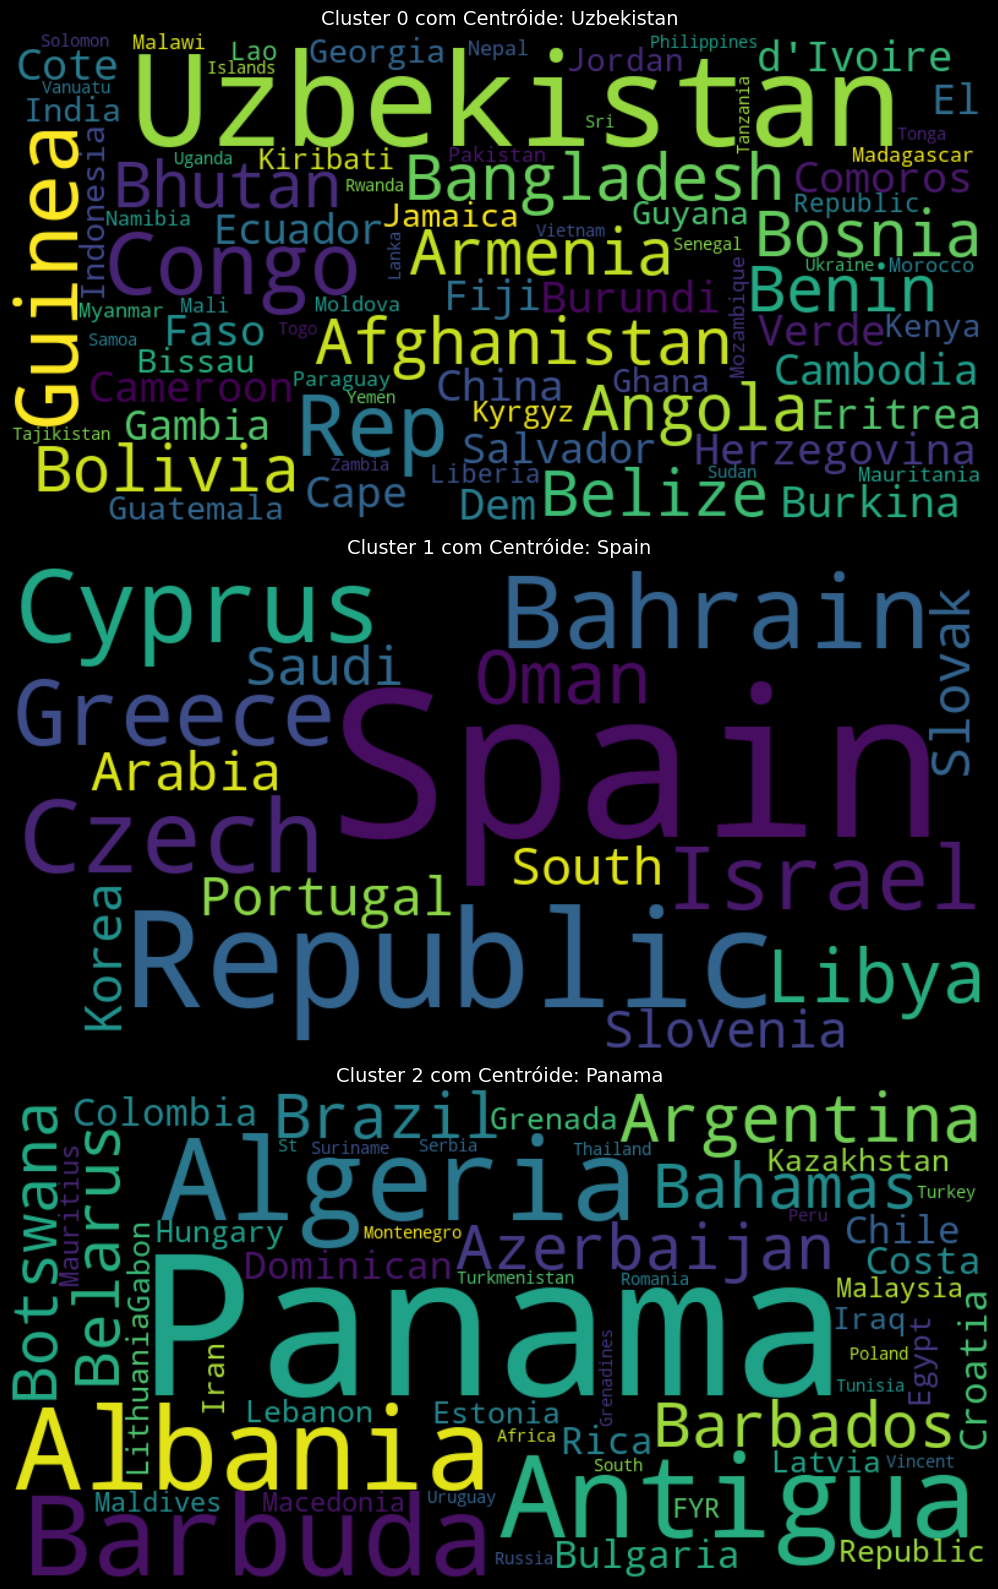

In [14]:
# Célula 5.6: Nuvem de Palavras por Cluster

# Importações
from wordcloud import WordCloud

# Criando uma nuvem de palavras para cada cluster
plt.figure(figsize=(20, 16))

for cluster_id in range(3):
    # Selecionando os países do cluster
    cluster_countries = country_names[data_cleaned['Cluster_KMeans'] == cluster_id]
    
    # Criando a string para a nuvem de palavras
    cluster_text = ' '.join(cluster_countries)
    cluster_text += f" {centroid_countries[cluster_id]}" * 5  # Destaca o centróide
    
    # Gerando a nuvem de palavras
    wordcloud = WordCloud(
        width=800, height=400, background_color='black', colormap='viridis'
    ).generate(cluster_text)
    
    # Plotando a nuvem de palavras
    plt.subplot(3, 1, cluster_id + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Cluster {cluster_id} com Centróide: {centroid_countries[cluster_id]}", fontsize=14)
    plt.axis('off')

plt.tight_layout()
plt.show()


## Hierachy

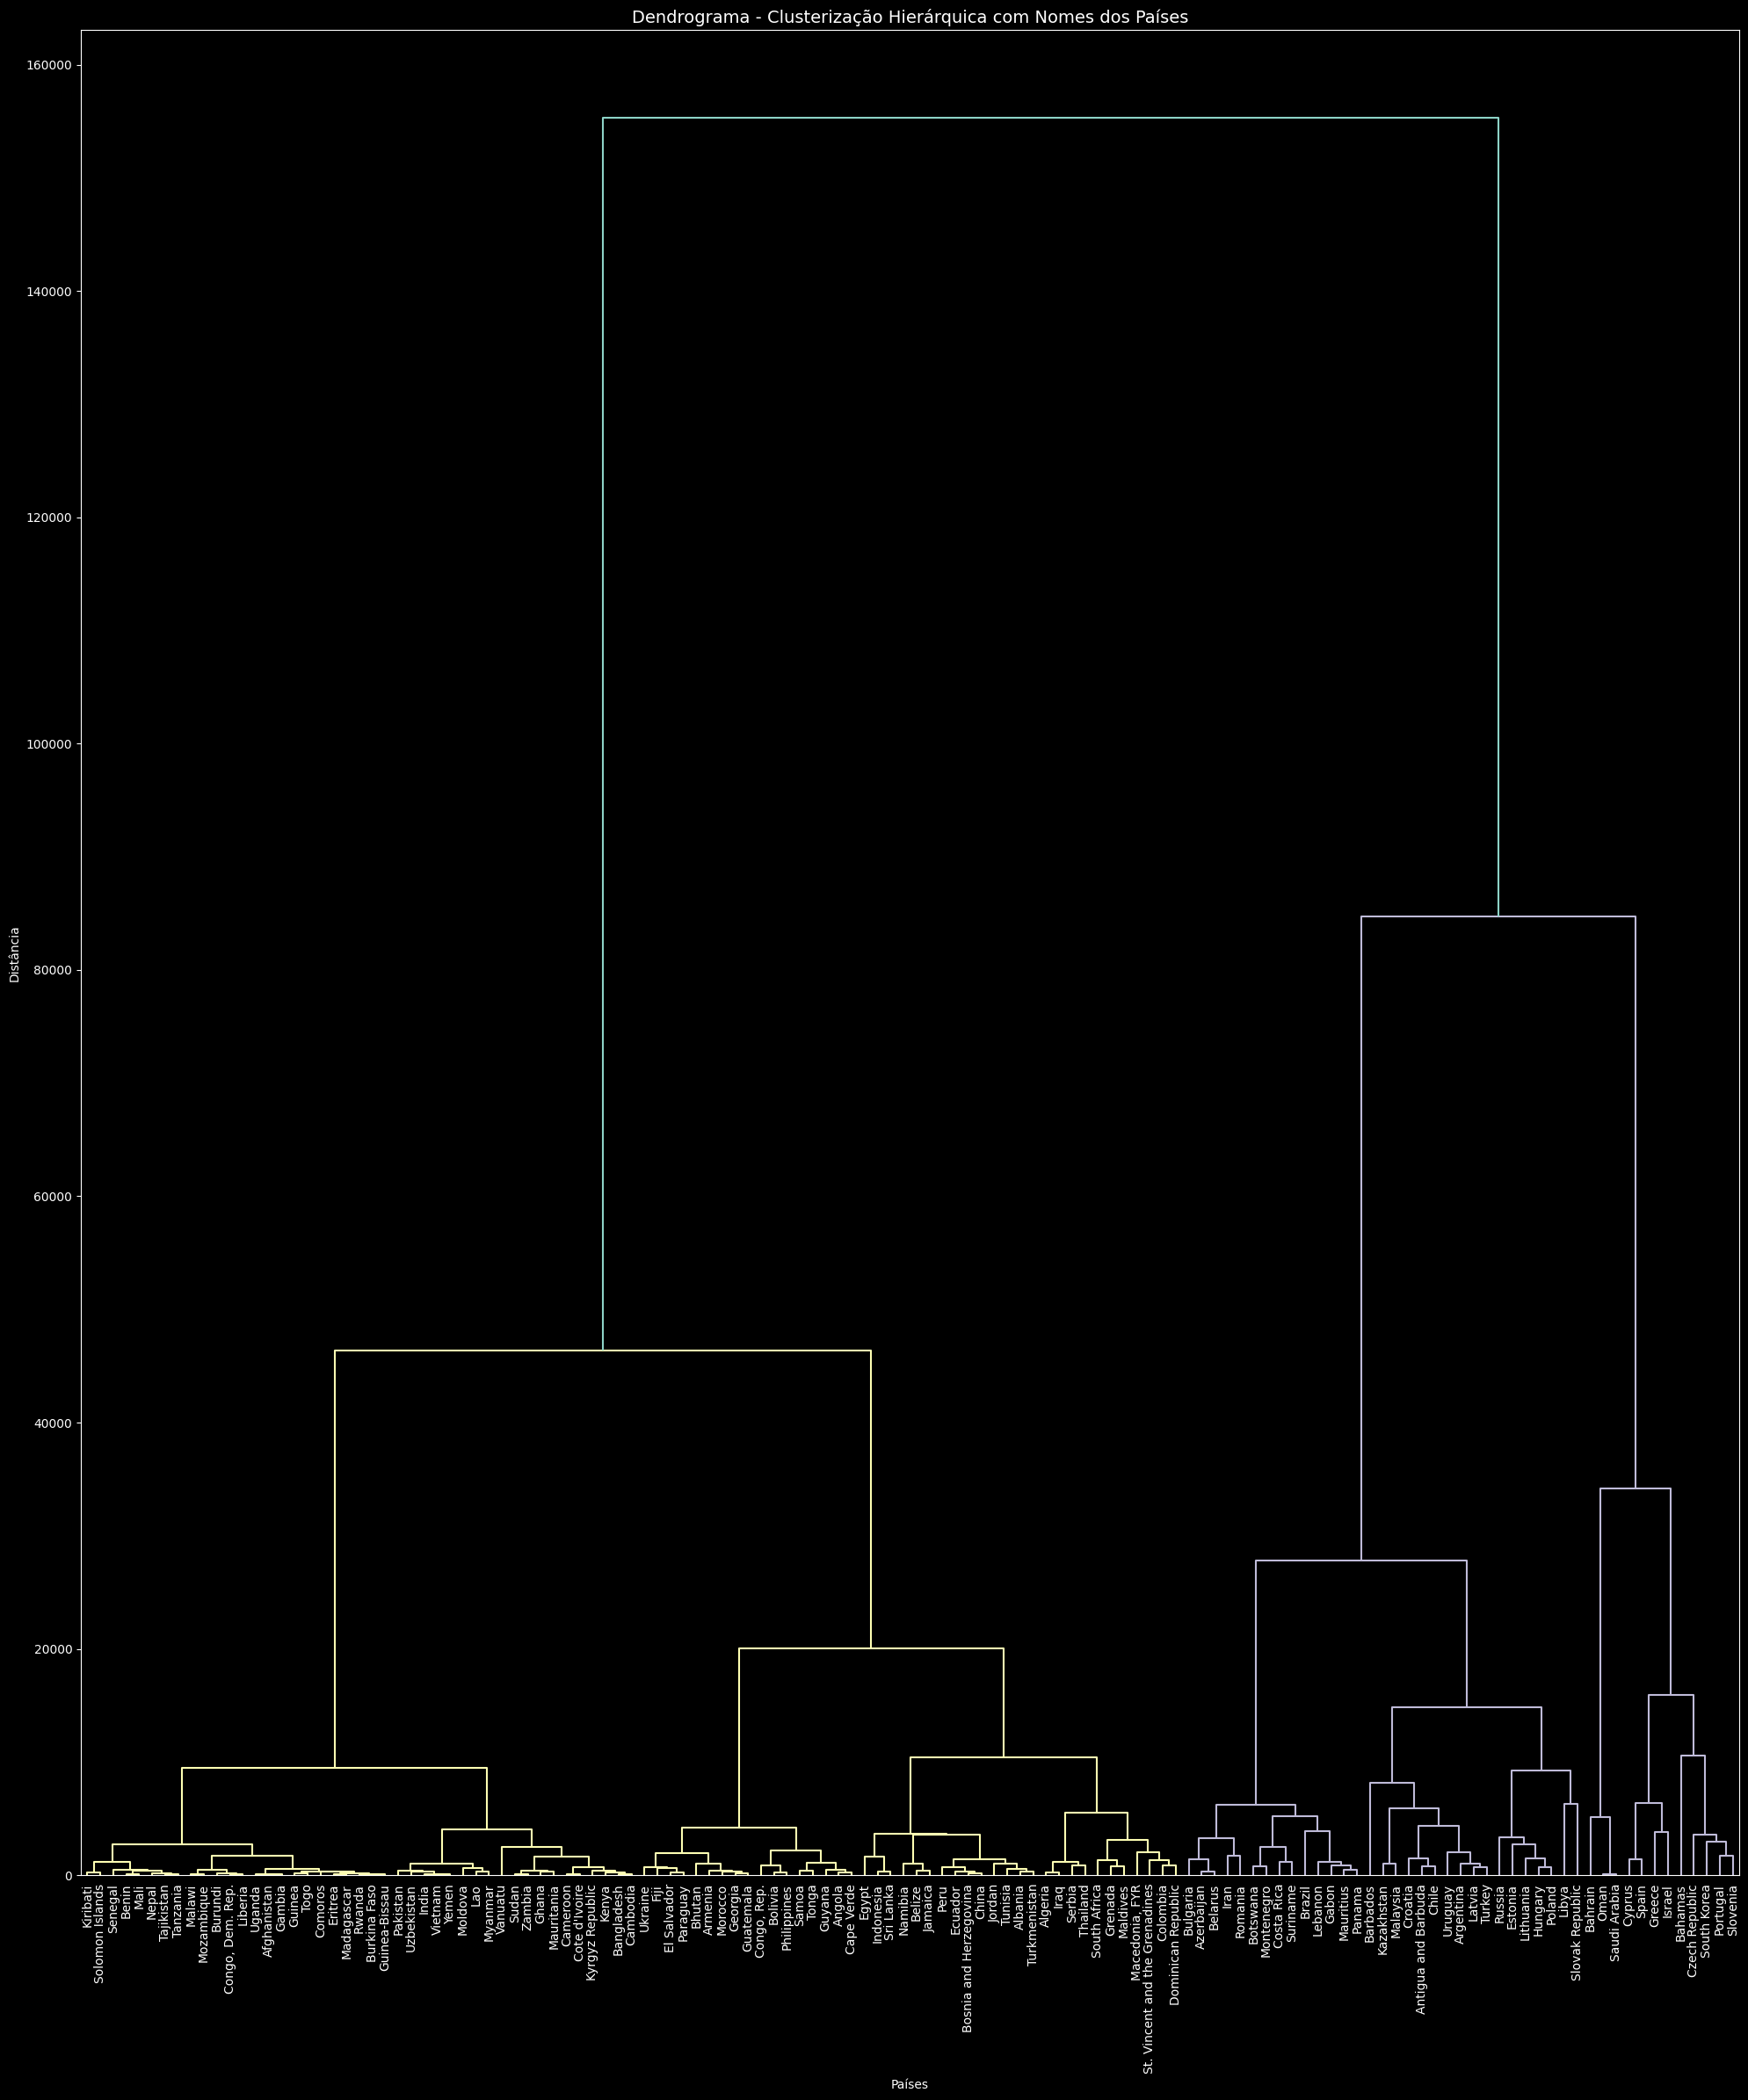

Definindo os clusters usando altura de corte (max_d)
Distribuição de países por cluster (Hierárquico):
Cluster_Hierarchical
1     24
2     19
3     17
4     14
11     7
6      7
13     5
9      5
7      5
5      4
8      4
20     4
18     2
10     2
16     2
19     2
21     1
12     1
17     1
14     1
15     1
Name: count, dtype: int64

Cluster 1: ['Afghanistan', 'Benin', 'Burkina Faso', 'Burundi', 'Comoros', 'Congo, Dem. Rep.', 'Eritrea', 'Gambia', 'Guinea', 'Guinea-Bissau', 'Kiribati', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mozambique', 'Nepal', 'Rwanda', 'Senegal', 'Solomon Islands', 'Tajikistan', 'Tanzania', 'Togo', 'Uganda']

Cluster 2: ['Bangladesh', 'Cambodia', 'Cameroon', "Cote d'Ivoire", 'Ghana', 'India', 'Kenya', 'Kyrgyz Republic', 'Lao', 'Mauritania', 'Moldova', 'Myanmar', 'Pakistan', 'Sudan', 'Uzbekistan', 'Vanuatu', 'Vietnam', 'Yemen', 'Zambia']

Cluster 3: ['Angola', 'Armenia', 'Bhutan', 'Bolivia', 'Cape Verde', 'Congo, Rep.', 'El Salvador', 'Fiji', 'Georgia', 'Guat

In [17]:
# Célula 6: Clusterização Hierárquica (com ajuste dinâmico de número de clusters e altura de corte)

# Importação
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

# Realizando a clusterização hierárquica
Z = linkage(data_cleaned.iloc[:, :-2], method='ward')  # Excluindo clusters para evitar interferência

# Recuperando os nomes dos países
country_names = data.loc[data_cleaned.index, 'country']  # Garante alinhamento com data_cleaned

# Ajustes de parâmetros
max_d = 4500  # Altura de corte ajustável
num_clusters = 4  # Número desejado de clusters

# Plotando o dendrograma com nomes dos países
plt.figure(figsize=(20, 24))
dendrogram(
    Z,
    labels=country_names.values,
    leaf_rotation=90,
    leaf_font_size=10,
)
plt.title("Dendrograma - Clusterização Hierárquica com Nomes dos Países", fontsize=14)
plt.xlabel("Países")
plt.ylabel("Distância")
plt.tight_layout()
plt.show()

# Determinando os clusters com base no critério selecionado
print(f"Definindo os clusters usando {'altura de corte (max_d)' if max_d else 'número de clusters'}")
if max_d:
    clusters_hierarchical = fcluster(Z, t=max_d, criterion='distance')  # Usando altura de corte
else:
    clusters_hierarchical = fcluster(Z, t=num_clusters, criterion='maxclust')  # Usando número de clusters

# Adicionando os clusters ao dataframe
data_cleaned['Cluster_Hierarchical'] = clusters_hierarchical

# Exibindo o número de elementos em cada cluster
print("Distribuição de países por cluster (Hierárquico):")
print(data_cleaned['Cluster_Hierarchical'].value_counts())

# Visualizando os clusters identificados
for cluster_id in range(1, num_clusters + 1):
    cluster_countries = country_names[data_cleaned['Cluster_Hierarchical'] == cluster_id]
    print(f"\nCluster {cluster_id}: {list(cluster_countries)}")


# Result

**Interpretação dos Resultados:**

K-Means:

Os clusters criados indicam agrupamentos coesos baseados na minimização de distâncias.
Países próximos ao centróide, como Índia, Líbano e Coreia do Sul, são bons representantes de seus respectivos clusters.
A distribuição no scatterplot com jitter reforça que os clusters são distintos, mas ainda apresentam sobreposições em regiões de transição.

Hierárquico:

O dendrograma oferece uma visão detalhada da hierarquia de agrupamentos, permitindo observar como países se unem progressivamente.
A altura de corte usada para definir os clusters reflete a similaridade/dissimilaridade geral entre os países. 
Alguns países podem ser visualizados como outliers (ex.: países que se unem ao final, como economias muito ricas ou muito pobres).

Conclusão

K-Means é mais prático e visualmente intuitivo para identificar padrões rápidos e interpretar centróides representativos. \
Hierárquico é mais flexível e oferece insights detalhados sobre a hierarquia de similaridades entre os países. \
Para este projeto, ambos os métodos fornecem resultados complementares, com o K-Means permitindo uma interpretação direta e o dendrograma hierárquico oferecendo maior profundidade na análise.

**Compare os dois resultados, aponte as semelhanças e diferenças e interprete.**

Os resultados dos modelos de clusterização revelaram agrupamentos coerentes entre países com características socioeconômicas e de saúde similares. No modelo de K-Means, os clusters foram definidos pela proximidade dos países aos centróides. \
Por exemplo, países como Índia, Líbano e Coreia do Sul se destacaram como representativos de seus clusters, refletindo aspectos econômicos, sociais e demográficos que os diferenciam. Países em desenvolvimento, caracterizados por renda per capita baixa e índices de saúde em desenvolvimento, foram agrupados em um cluster, enquanto economias avançadas, com alta renda e bons índices de saúde, formaram outro. O modelo mostrou maior homogeneidade dentro dos clusters, com base na minimização de distâncias, e as semelhanças foram reforçadas no gráfico reduzido por PCA.

Na Clusterização Hierárquica, o dendrograma destacou como os países se unem progressivamente em grupos, refletindo sua similaridade incremental. \
Os países agrupados em estágios iniciais compartilham características como PIB e expectativa de vida similares, enquanto outliers, como economias extremas, se unem apenas em estágios finais. Este modelo destacou nuances adicionais, como subgrupos em economias emergentes e variações dentro de clusters maiores, oferecendo maior profundidade na análise. \
Em ambos os métodos, variáveis como índices de saúde, acesso à educação e estabilidade econômica foram determinantes para as semelhanças entre países, proporcionando uma visão clara da estrutura global dos dados analisados.

**Escreva em tópicos as etapas do algoritmo de K-médias até sua convergência.**

Inicialização: Seleciona 
𝑘
k pontos iniciais como centróides, podendo ser aleatórios ou otimizados (ex.: K-Means++).

Atribuição: Cada ponto dos dados é atribuído ao cluster cujo centróide está mais próximo, com base em uma métrica de distância (geralmente, distância euclidiana).

Recalcular Centróides: Para cada cluster formado, calcula o novo centróide como a média dos pontos atribuídos a ele.

Reatribuição: Reatribui os pontos aos clusters com base nos novos centróides.

Convergência: O processo de recalcular centróides e reatribuir pontos continua até que:

Os centróides não se movam significativamente entre iterações.
Ou um número máximo de iterações seja atingido.

# Medóide   

Países representando os clusters (Medóides):
Cluster 0: Moldova
Cluster 1: Gabon
Cluster 2: South Korea


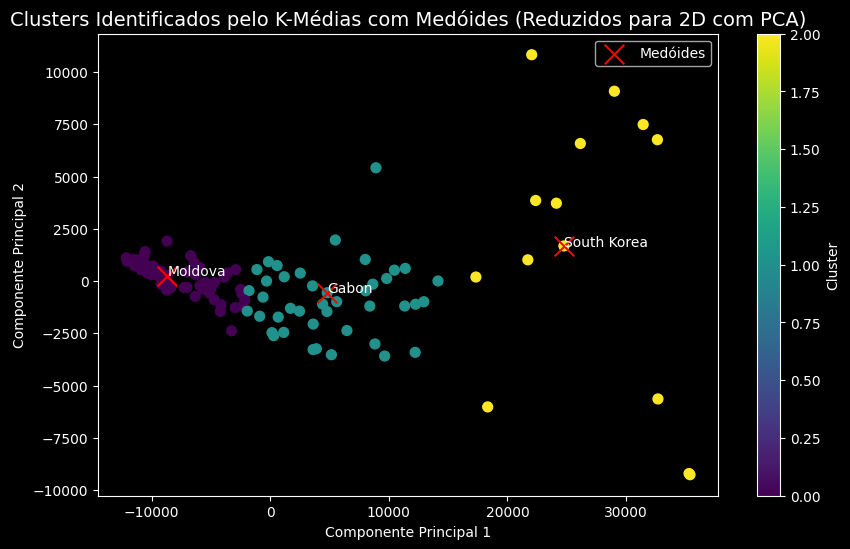

In [21]:
# Célula 7: Clusterização com K-Médias usando Medóides

# Importações
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Função para K-Médias com medóides
def kmeans_with_medoid(data, n_clusters, max_iter=300, tol=1e-4, random_state=42):
    np.random.seed(random_state)
    
    # Inicialização: Escolha aleatória dos centróides
    initial_centroids_idx = np.random.choice(len(data), n_clusters, replace=False)
    centroids = data[initial_centroids_idx]

    for i in range(max_iter):
        # Atribuição: Calcula o cluster mais próximo para cada ponto
        labels = np.argmin(np.linalg.norm(data[:, np.newaxis] - centroids, axis=2), axis=1)

        # Recalcular centróides: Encontra o ponto mais próximo do baricentro (medóide)
        new_centroids = []
        medoids = []
        for cluster in range(n_clusters):
            cluster_points = data[labels == cluster]
            if len(cluster_points) > 0:  # Certifique-se de que o cluster não está vazio
                centroid = cluster_points.mean(axis=0)
                medoid = cluster_points[np.argmin(np.linalg.norm(cluster_points - centroid, axis=1))]
                new_centroids.append(centroid)
                medoids.append(medoid)
            else:
                # Caso o cluster esteja vazio, mantenha o medóide anterior
                new_centroids.append(centroids[cluster])
                medoids.append(centroids[cluster])

        new_centroids = np.array(new_centroids)
        medoids = np.array(medoids)

        # Verificar convergência (mudança mínima nos medóides)
        if np.all(np.linalg.norm(medoids - centroids, axis=1) < tol):
            break

        centroids = medoids  # Atualiza os medóides para a próxima iteração

    return labels, medoids

# Aplicando o algoritmo corrigido
data_array = data_cleaned.iloc[:, :-2].values
n_clusters = 3
labels, medoids = kmeans_with_medoid(data_array, n_clusters)

# Adicionando os rótulos ao dataframe
data_cleaned['Cluster_Medoids'] = labels

# Recuperando os nomes dos países
medoid_countries = []
for medoid in medoids:
    distances = np.linalg.norm(data_array - medoid, axis=1)
    closest_country_index = distances.argmin()
    medoid_countries.append(country_names.iloc[closest_country_index])

# Exibindo os nomes dos países representativos (medóides)
print("Países representando os clusters (Medóides):")
for i, country in enumerate(medoid_countries):
    print(f"Cluster {i}: {country}")


# Visualizando os clusters em um gráfico 2D (usando PCA para redução de dimensionalidade)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_array)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    data_pca[:, 0], data_pca[:, 1], 
    c=labels, cmap='viridis', s=50
)

# Adicionando os medóides ao gráfico
medoids_pca = pca.transform(medoids)
plt.scatter(medoids_pca[:, 0], medoids_pca[:, 1], 
            c='red', marker='x', s=200, label='Medóides')

# Anotando os nomes dos países nos medóides
for i, txt in enumerate(medoid_countries):
    plt.annotate(txt, (medoids_pca[i, 0], medoids_pca[i, 1]), fontsize=10, color='white')

plt.title("Clusters Identificados pelo K-Médias com Medóides (Reduzidos para 2D com PCA)", fontsize=14)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.show()


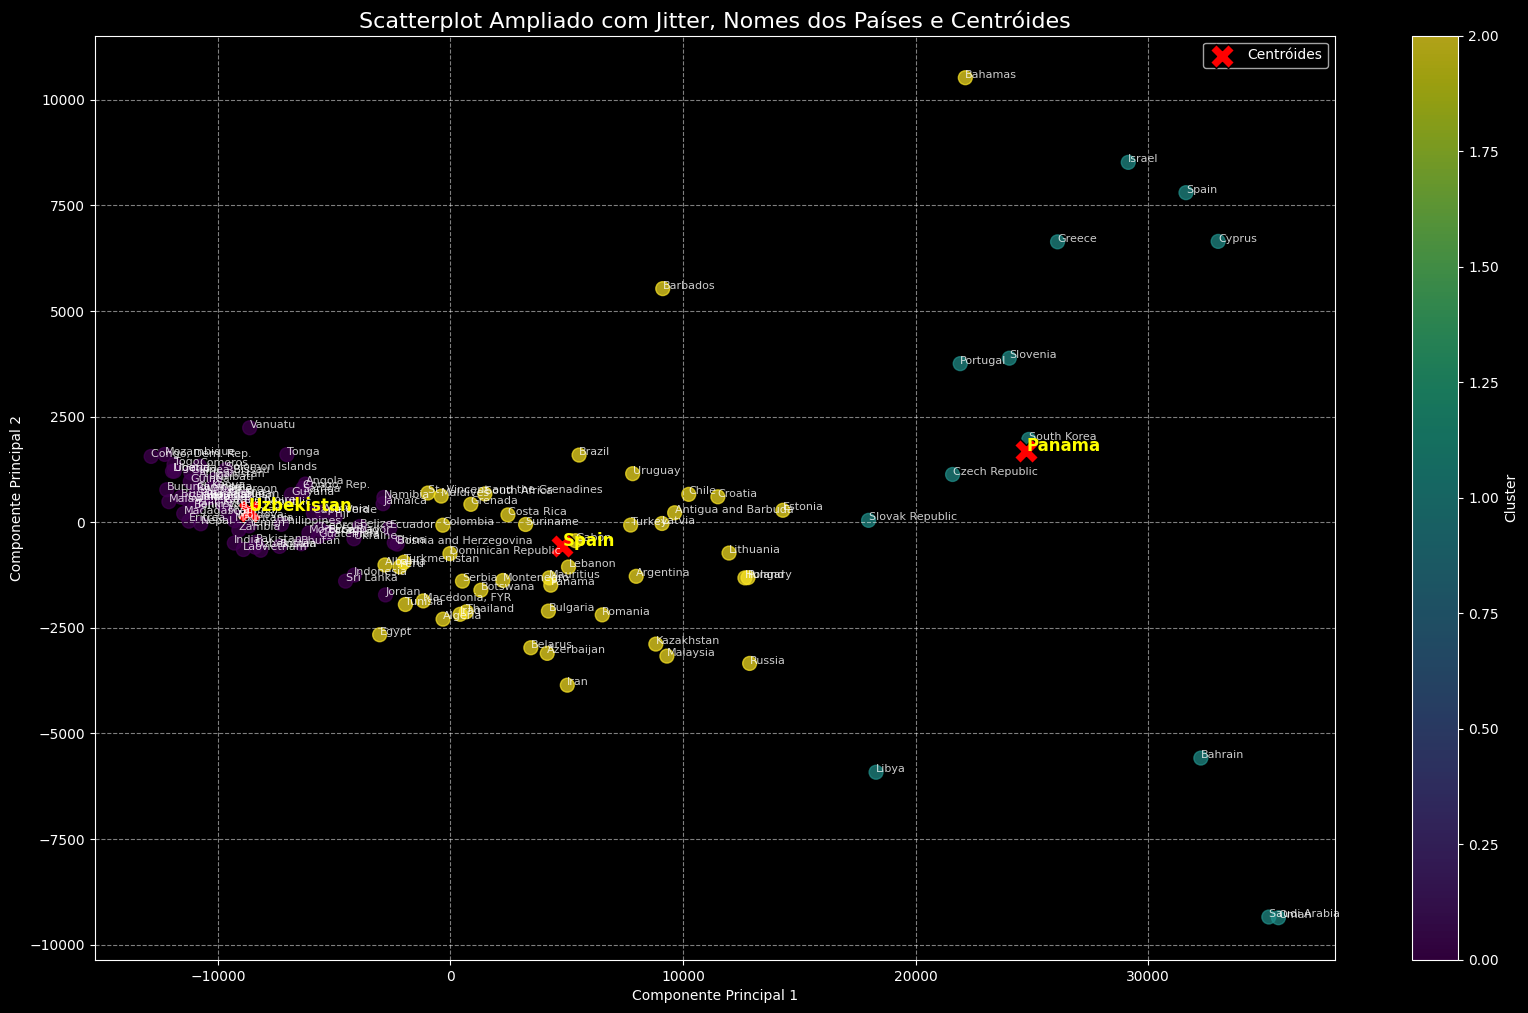

In [22]:
# Célula 7.5: Scatterplot Ampliado Centróides e Medóides

import matplotlib.pyplot as plt
import numpy as np

# Adicionando jitter (ruído aleatório pequeno) às coordenadas
jitter_strength = 300 # Ajuste para controlar a intensidade do espalhamento
data_pca_jittered = data_pca + np.random.normal(0, jitter_strength, data_pca.shape)


# Plotando os clusters em 2D com centróides destacados
plt.figure(figsize=(20, 12))
scatter = plt.scatter(
    data_pca_jittered[:, 0], data_pca_jittered[:, 1],
    c=data_cleaned['Cluster_KMeans'], cmap='viridis', s=100, alpha=0.7
)

# Adicionando os nomes dos países a cada ponto
for i, txt in enumerate(country_names):
    plt.annotate(txt, (data_pca_jittered[i, 0], data_pca_jittered[i, 1]), fontsize=8, alpha=0.8, color='white')

# Adicionando os centróides ao gráfico (sem jitter nos centróides)
plt.scatter(medoids_pca[:, 0], medoids_pca[:, 1], 
            c='red', marker='X', s=300, label='Centróides', edgecolors='black')

# Adicionando os nomes dos países próximos aos centróides
for i, txt in enumerate(centroid_countries):
    plt.annotate(txt, (medoids_pca[i, 0], medoids_pca[i, 1]), fontsize=12, color='yellow', weight='bold')

plt.title("Scatterplot Ampliado com Jitter, Nomes dos Países e Centróides", fontsize=16)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()



**O algoritmo de K-Médias é sensível a outliers nos dados. Explique.** \
O algoritmo de *K-Média*s minimiza a variância dentro dos clusters utilizando centróides como o baricentro de cada grupo. Por definição, o centróide é calculado como a média aritmética dos pontos atribuídos ao cluster, o que significa que ele pode ser significativamente deslocado por outliers, pois valores extremos afetam a média. \ No nosso trabalho, essa sensibilidade seria especialmente problemática para dados como índices de saúde ou renda per capita, onde países muito ricos ou muito pobres poderiam distorcer os clusters.

No contexto do projeto, identificamos que o K-Médias tradicional pode formar clusters onde um único país atípico, como uma grande economia ou um país com indicadores extremos, influencia desproporcionalmente o centróide e, consequentemente, a composição do cluster. Ao adaptar o algoritmo para utilizar medóides, mitigamos esse problema, já que os medóides representam pontos reais da base e não são afetados diretamente por outliers. Apesar disso, o K-Médias ainda não é ideal em situações onde há muitos dados ruidosos ou fortemente discrepantes.

**Por que o algoritmo de DBScan é mais robusto à presença de outliers?** \
O *DBScan* (Density-Based Spatial Clustering of Applications with Noise) é mais robusto à presença de outliers porque ele identifica grupos com base na densidade dos dados, ao invés de depender de métricas globais como médias ou centróides. O algoritmo classifica pontos em três categorias:

**Núcleo**: Pontos que têm pelo menos um número mínimo de vizinhos dentro de uma distância definida. \
**Fronteira**: Pontos que estão próximos a um núcleo, mas não atendem ao critério de densidade mínima. \
**Ruído (outliers)**: Pontos que não pertencem a nenhuma das duas categorias anteriores. \

No nosso escopo, o DBScan seria ideal para lidar com dados socioeconômicos porque pode separar naturalmente países com características extremas (outliers) como dados de ruído, sem forçá-los a pertencer a um cluster. Isso o torna mais adequado para cenários como o nosso, onde as diferenças entre economias e indicadores de saúde são muito amplas. No entanto, a desvantagem do DBScan é que ele exige uma escolha cuidadosa dos parâmetros (distância Euclidiana ε e densidade mínima), que podem não ser triviais de determinar em bases de dados multidimensionais como a utilizada no projeto.